## Introduction 

My feature data is based on 2,000+ Reddit posts, which pertained to stocks that were in the top-10 by daily retail trader activity on the day after they were posted. The dataset has 35,403 columns, which is because they represent a vectorized corpus of text data. The texts originally contained about 50,000 plus columns, but the number of columns was filtered down by first lowercasing and stemming the words (removing about 7,000) and then removing words which only appeared one time (removing a further ~9,000 columns).

In my analysis, I am hoping to use clustering to study whether there are interesting structures and relationships between the language used in these 2,000 posts. I am hoping that clusters might reflect certain kinds of posts (as there are several archetypes visible on the forum pages), or, further, that the clusters might reveal some previously unseen groupings in the data. These groupings could be findings in themselves, or they could be avenues for future analysis. In addition, I will compare the clusters returned by the various algorithms with my outcome variable (whether the given stock being written about increased or decreased in activity the next day), to understand if the clustering has inadvertently classified the outcome variable in some form.


## Theory

### K Means Clustering 

K means clustering uses repeated placement of centroids and assignment of nearby points to try and minimize the within-cluster variance (squared distance from the centroid to all points). To begin K means clustering, the algorithm would randomly initialize a given number of centroids, which we refer to as K centroids. Then, the algorithm would assign all points in the space to clusters based on their closest centroid. A real-life analogy to this would be drawing a property line midway between two houses, so that the line sat halfway in the distance between them, and then all points which fell on either side of the property line would be considered in that "houses" cluster. Where the houses are the centroids. 

Next, the algorithm would move the centroids, this time placing them not randomly, but rather at the point which minimizes the squared distance to all of the points in their cluster. Then, the points are reassigned to the nearest centroid, and the process repeats. This process can converge quickly, or fail to converge in some rare cases, but on average it performs reasonably well at generating clusters that minimize the within-cluster squared distances to the centroids. In the property line example, it would be similar to how many houses are on rectangular lots, because the house behind them is further away than the house next door. But after drawing the initial property rectangle, the house would be relocated to the "center" of their property, and then the property lines would be moved so as to remain at the halfway point between each house. This would guarantee that the yards were as close to their respective houses (in squared distance) as possible. 

### Hierarchical Clustering

Hierarchical clustering works very differently from K means clustering. In hierarchical clustering, clusters can exist on multiple layers. Rather than a  piece of property which must fall squarely in one house's lot, a datapoint in a hierarchical cluster is more like a person in a family tree, where they could have many layers of other people above them. In this type of clustering, the algorithm can either proceed from the bottom up (forming small groups and then tying them together) or the top down (starting with the broadest categories and then dividing them further). Pretend we are at a family BBQ, and we want to identify the family tree that maps the relationships of all individuals there. We could start with the oldest person, and then trace their descendants, which would be top down hierarchical clustering. But we could also start with the children, identify their parents, and then their parents' parents, and so on. Both options can be used in practice.

One advantage of hierachical clustering is that it does not require the user to input a value for K. Based on the way that the model tries to build the tree, it will ultimately decide upon the number of appropriate clusters itself. Hierarchical clustering can be a very good fit for some kinds of datasets where the desired clusters could be subsets of eachother, like trying to identify species and families from datasets of fossils, or trying to identifying familial groupings in a reunion. Hierarchical clustering can be evaluated by a Silouhette plot, which measures how separated the clusters in the dataset are.


### DBSCAN

DBSCAN is a popular clustering method that workds based on density. In other words, it assigns clusters to dense areas with sparse areas in between them. This fundamental principle allows DBSCAN to work on nonlinear clusters, because all that matters is that the algorithm can distinguish an area of low density separating the higher density clusters. DBSCAN clustering is able to find high and low density areas based on the distances between points and their closest neighbors. If you imagine a sparse area of a plot, a given point will have higher average distances to its nearest neighbors than in a tight cluster.

DBSCAN is useful for many applications, because many types of data exhibit nonlinear behavior. In my application for this dataset, DBSCAN is appealing because there may not be linear patterns in the text data I am investigating, but density in the usage of certain words could still form meaningful clusters. In terms of hyperparameters, DBSCAN also does not need to know the number of clusters ahead of time, which makes it an even more flexible method for a variety of situations. DBSCAN can also be evaluated using Silhouette plots, as the ideal algorithm will have clearly distinct clusters with meaningful distances between them. 



## Methods

First, I will read in and clean my stock ticker and reddit post text data. This will be done via Jupyter notebook, and common packages such as pandas, matplotlib, and sklearn.

Second, I will merge the two datasets together, so that the reddit posts are associated with particular stocks on given days. 

Third, I will filter to only keep the days for which reddit posts were present (the 2000+ observations mentioned above).

Fourth, I remove any columns other than the text data in order to feed purely textual data into the clustering algorithms.

Fifth, I will declare the functions that will fit the various clustering methods and also iterate over possible hyperparameters.

Sixth, I will feed my data into the functions, and review the outputs for each possible hyperparameter value (by reviewing the elbow and silhouette plots).

Seventh, I will run the final model and view the clustered data along various axes until I ultimately pick one that is a good representation of the clustering results. (You will only see the final selected plots below.)

## Code Implementation 

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.cluster
import pandas as pd



In [50]:
# read in data, merge using code from naive bayes
dataIn = pd.read_csv("../data/01-modified-data/joinedSentiment.csv")
dataIn.shape

textsIn = pd.read_csv("../data/01-modified-data/vectorizedReddit.csv")
textsIn.shape

s = textsIn.sum(axis=0)
textsIn=textsIn[ s.index[s != 1]   ]
textsIn.shape

from datetime import datetime, timedelta
dataIn['date.x'] = dataIn['date.x'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
dataIn['date.x'] = dataIn['date.x'] - timedelta(days = 1)


# Join
textsIn = pd.DataFrame(textsIn)
textsIn['date_utc'] = textsIn['date_utc'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
processed = pd.merge(dataIn, textsIn, how = 'left', left_on = ['date.x', 'ticker'], right_on = ['date_utc', 'ticker'] )


In [24]:
processed2 = processed.dropna(subset=['date_utc'])
print(processed2.shape)

# exclude nonnumeric data
exclude = ['Bullish','Spread','SPYHighWk','SPYLowWK','SPYCloseWK','lagweek','date_utc','title','Bearish','Neutral', 'Unnamed: 0', 'X', 'date.x', 'X8.week', 'Total', 'week.y', 'date.y', 'deltaActivity', 'weekyear', '' 'ticker', 'activity_x', 'sentiment_x', 'deltaSentiment', 'newEntry', 'week.x']


processed2['activityIncrease'] = processed2['deltaActivity'].apply(lambda x: int(x > 0) )

processed3 = processed2.drop(columns = exclude, axis = 1)

processed3.head()
X = processed3.drop('activityIncrease', axis=1)
y = processed3['activityIncrease']

(2018, 35427)


C:\Users\corwi\AppData\Local\Temp\ipykernel_34132\1696908631.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed2['activityIncrease'] = processed2['deltaActivity'].apply(lambda x: int(x > 0) )


In [25]:
# Clustering code from the labs, used as the start for this page


# Define a function to generate 2D clusters with normal distributions.
def generate_2D_normal_clusters(points_per_cluster=200, num_cluster=3, correlated=True):
    # Initialize an empty dictionary to store the generated clusters.
    sets = {}

    # Loop to generate multiple clusters.
    for cluster in range(0, num_cluster):
        # Randomly select the number of points for this cluster within a range.

        # Define parameters for a 2D normal distribution.
        L = 10  # A scaling factor
        # Randomly select the mean (center) of the distribution in X and Y.
        ux = np.random.uniform(-L, L, size=1)[0]
        uy = np.random.uniform(-L, L, size=1)[0]
        # Randomly select the standard deviation in X and Y.
        sx = np.random.uniform(0.1 * L, 0.25 * L, size=1)[0]
        sy = np.random.uniform(0.1 * L, 0.25 * L, size=1)[0]
        # Randomly select the correlation between X and Y (Pearson correlation).
        rho = np.random.uniform(0.0, 0.99, size=1)[0]

        # Create the mean vector and covariance matrix for the distribution.
        u = np.array([ux, uy])
        S = np.array([[sx**2.0, rho * sy * sx], [rho * sy * sx, sy**2.0]])

        # If 'correlated' is False, set the off-diagonal elements of the covariance matrix to 0.
        if correlated == False:
            S[0, 1] = 0
            S[1, 0] = 0

        # Generate points from the multivariate normal distribution defined by 'u' and 'S'.
        x1, x2 = np.random.multivariate_normal(u, S, points_per_cluster).T

        # Create or concatenate the data and labels for the clusters.
        if cluster == 0:
            X = np.array([x1, x2]).T  # Data
            y = cluster * np.ones(points_per_cluster)  # Labels
        else:
            X = np.concatenate((X, np.array([x1, x2]).T), axis=0)
            y = np.concatenate((y, cluster * np.ones(points_per_cluster)), axis=0)

    # Return the generated data (X) and labels (y).
    return X, y

# Generate the data for machine learning.
num_clusters_real = 1 + int(7 * np.random.uniform(0, 1))  # Determine the number of clusters.
print(num_clusters_real)


# Print the shape of the generated data and labels.
print(X.shape, y.shape)

# Make sure that the data is stored as a contiguous array for efficient memory access.
X = np.ascontiguousarray(X)

3
(2018, 35402) (2018,)


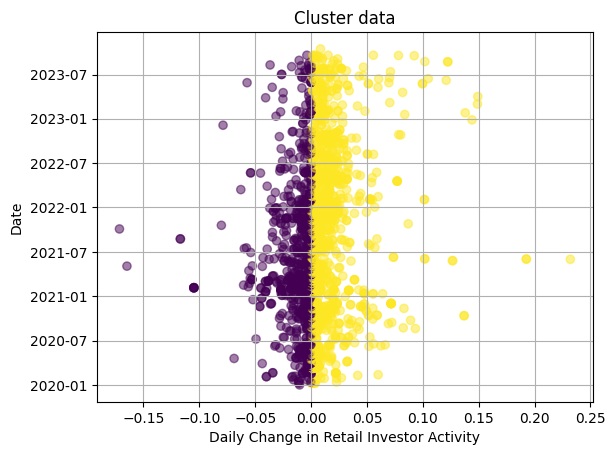

In [37]:
# helper function to visualize clusters in a given dataset, used as an example here 
def plot(X,color_vector):
    fig, ax = plt.subplots()
    ax.scatter(processed2.loc[:,'deltaActivity'], processed2.loc[:,'date_utc'],c=color_vector, alpha=0.5) #, c=y
    ax.set(xlabel='Feature-1 (x_1)', ylabel='Feature-2 (x_2)',
    title='Cluster data')
    plt.xlabel('Daily Change in Retail Investor Activity')
    plt.ylabel('Date')
    ax.grid()
    # fig.savefig("test.png")
    plt.show()

plot(X,y)

In [27]:
# THIS WILL ITERATE OVER ONE HYPER-PARAMETER (GRID SEARCH)
# AND RETURN THE CLUSTER RESULT THAT OPTIMIZES THE SILHOUETTE SCORE
def maximize_silhouette(X,algo="birch",nmax=20,i_plot=False):

    # PARAM
    i_print=False

    #FORCE CONTIGUOUS
    X=np.ascontiguousarray(X)

    # LOOP OVER HYPER-PARAM
    params=[]; sil_scores=[]
    sil_max=-10
    for param in range(2,nmax+1):
        if(algo=="birch"):
            model = sklearn.cluster.Birch(n_clusters=param).fit(X)
            labels=model.predict(X)

        if(algo=="ag"):
            model = sklearn.cluster.AgglomerativeClustering(n_clusters=param).fit(X)
            labels=model.labels_

        if(algo=="dbscan"):
            param=0.25*(param-1)
            model = sklearn.cluster.DBSCAN(eps=param).fit(X)
            labels=model.labels_

        if(algo=="kmeans"):
            model = sklearn.cluster.KMeans(n_clusters=param).fit(X)
            labels=model.predict(X)

        try:
            sil_scores.append(sklearn.metrics.silhouette_score(X,labels))
            params.append(param)
        except:
            continue

        if(i_print): print(param,sil_scores[-1])

        if(sil_scores[-1]>sil_max):
             opt_param=param
             sil_max=sil_scores[-1]
             opt_labels=labels

    print("OPTIMAL PARAMETER =",opt_param)

    if(i_plot):
        fig, ax = plt.subplots()
        ax.plot(params, sil_scores, "-o")
        ax.set(xlabel='Hyper-parameter', ylabel='Silhouette')
        plt.show()

    return opt_labels

c:\Users\corwi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\corwi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\corwi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\corwi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\clus

OPTIMAL PARAMETER = 2


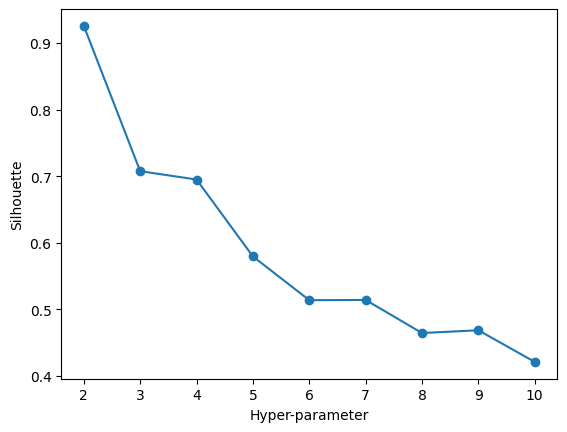

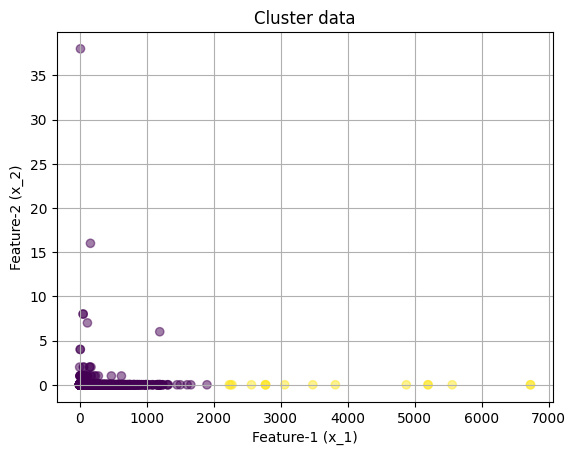

In [31]:
opt_labels=maximize_silhouette(X,algo="kmeans",nmax=10, i_plot=True)


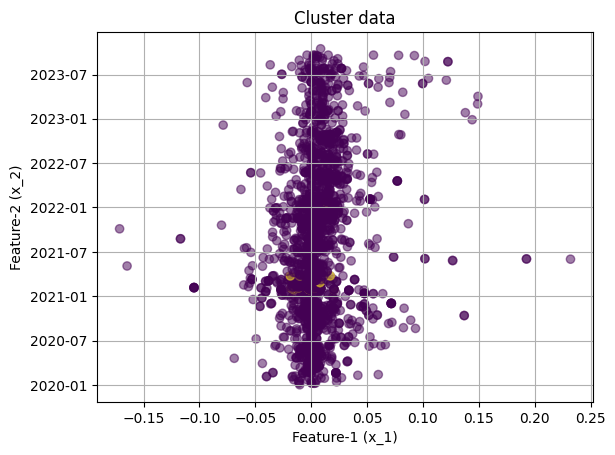

In [35]:
plot(X,opt_labels)


OPTIMAL PARAMETER = 2


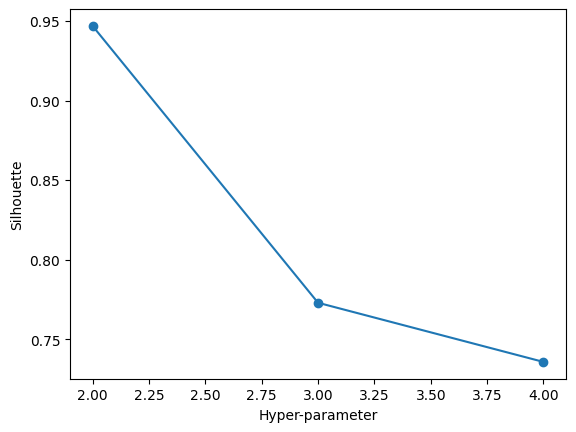

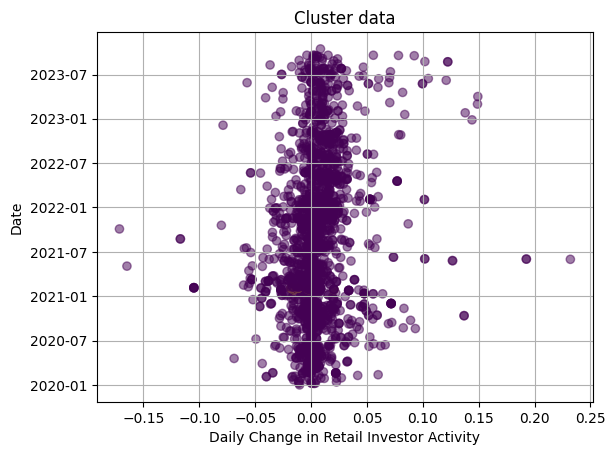

In [53]:
opt_labels=maximize_silhouette(X,algo="ag",nmax=4, i_plot=True)
plot(X,opt_labels)

OPTIMAL PARAMETER = 0.25


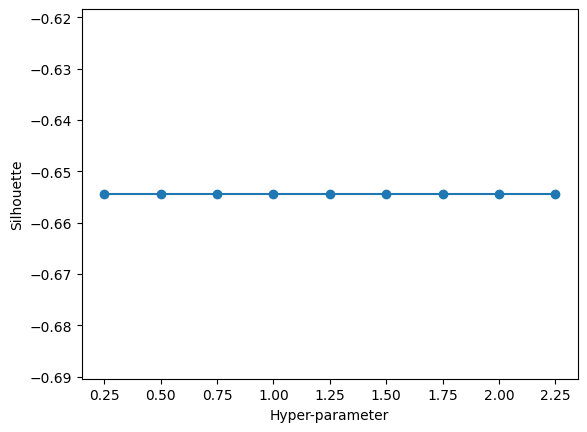

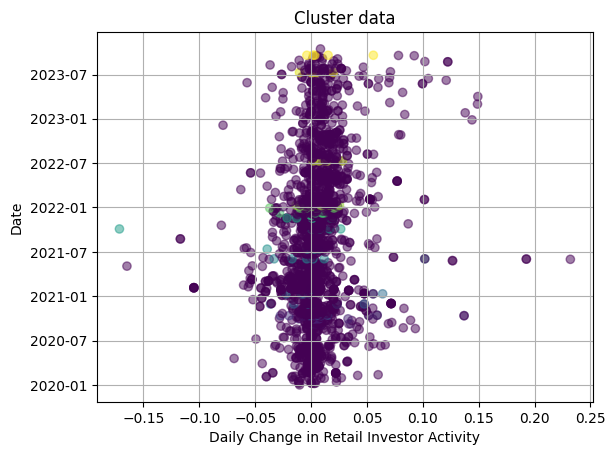

In [41]:
opt_labels=maximize_silhouette(X,algo="dbscan",nmax=10, i_plot=True)
plot(X,opt_labels)


## Hyper Parameter Tuning and Results 

Across the models, hyper parameter tuning was accomplished with silhouette plots, where I looked for the maximum silhouette value for each model. Hierarchical clustering struggled both computationally and in its performance. While the ideal hyperparameter in the silhouette plot was 2 for the maximum value of N, the agglomerative clustering did not produce meaningful clusters no matter what axes I viewed them on. I believe this may be because the structure of the data prevented the hierarchical approach from working well, given that I have many points which could not be related to any other points given that they might have had totally unique language and thus total uniqueness in the dataset. While the other methods simply grouped most points together and identified ones which stood out from the pack, perhaps hierarchical clustering could not accomplish the same feat and struggled to accomodate the many virtually patternless points. 

DBSAN did not change in its performance regardless of the hyperparameter selected. This is expected as the hyperparameter is not the same as the other two models, because DBSAN does not require us to input the number of clusters. However, DBSAN did reveal interesting features in the data. Plotting the clusters vs. the change in retail activity on the X axis and time on the Y axis (chart above) showed that DBSAN had identified small clusters that were very closely related in time. I believe the reason for this is that DBSAN creates clusters based on density, and given that our feature space is the language used in reddit posts, this means that DBSAN has identified clusters of similar posts throughout the data. These posts actually make intuitive sense, because reddits sometimes work like echo chambers, where particular stocks such as GAMESTOP or AMC become very popular to discuss and trade for a small period of time. This would lead posts from this period to become more similar, as they are discussing the same point, which then makes the clustering algorithm identify them together. When viewed over time, we then see that the clusters have selected small points in time, due to the way the data was generated. DBSAN revealed this pattern in the data, which I found quite interesting.

The silhouette plot for K-means was very clear: The value decreased for each additional mean that was added to the model. As such, the smallest value, with only 2 clusters, appeared to be the ideal choice for the data. But upon reviewing the clusters that were returned along many axes, there did not appear to be a meaningful interpretation of the data they represented, even with the ideal K value. This was mainly because one cluster contained almost all of the data in the dataset, which meant that the secondary cluster did not yield many interesting results, and was also largely impossible to pick out in any of the charts. I believe this shows that the data did not lend itself to linear separability, as DBSAN performed much better than Kmeans at identifying interesting features.





## Conclusions 

Out of the three clustering methods, DBSCAN provided the most interesting results for my study. In particular, the DBSCAN plot showed stratified clusters of points within the timeline of the data. I believe these could correspond to events or moments of excitement about particular stocks, which led to repeated posts using similar language, which in turn made those posts seem more similar to the clustering algorithm. Because DBSCAN focuses on areas of relative density and sparseness, it was able to identify these small moments within the larger dataset. In contrast, K means might have been confused by nonlinearity, or the relative rarity of these datapoints within the corpus. 




## References ##

No outside works used that need to be cited. Lab code was used for the clustering functions.